In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
import lightgbm as lgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [2]:
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv")

In [3]:
data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
sub.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [5]:
data.shape

(98000, 30)

In [6]:
sub.shape

(98000, 2)

**EDA**

In [7]:
data.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,...,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,...,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,...,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,...,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,...,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,...,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,...,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,...,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


<AxesSubplot:>

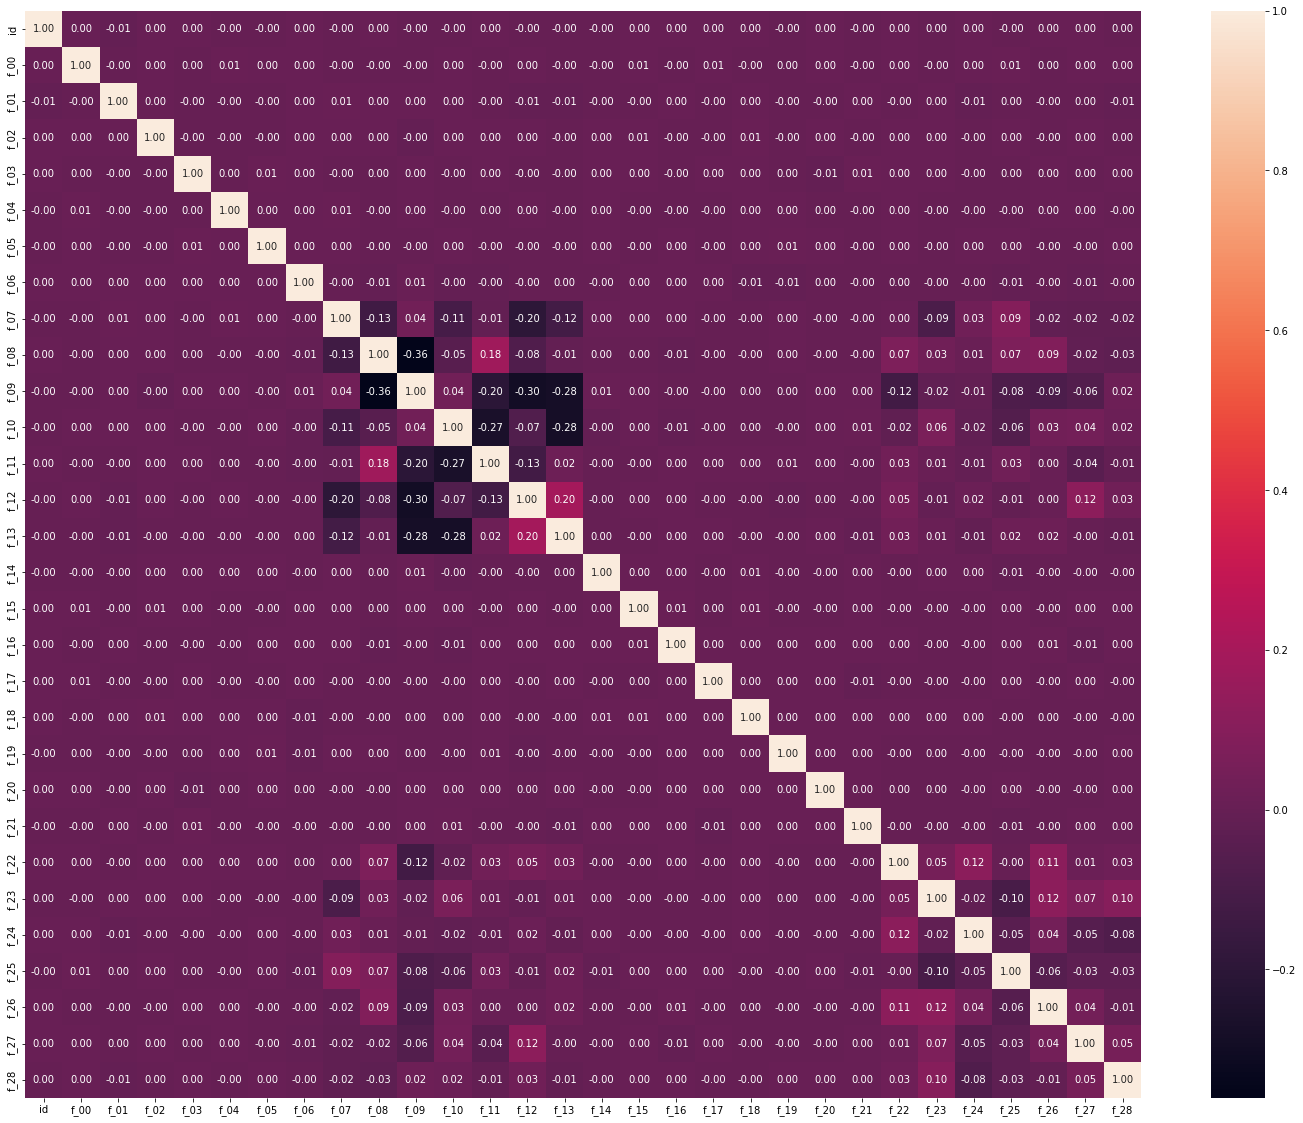

In [8]:
plt.figure(figsize = (25,20))
sns.heatmap(data.corr(),annot = True,fmt = ".2f")

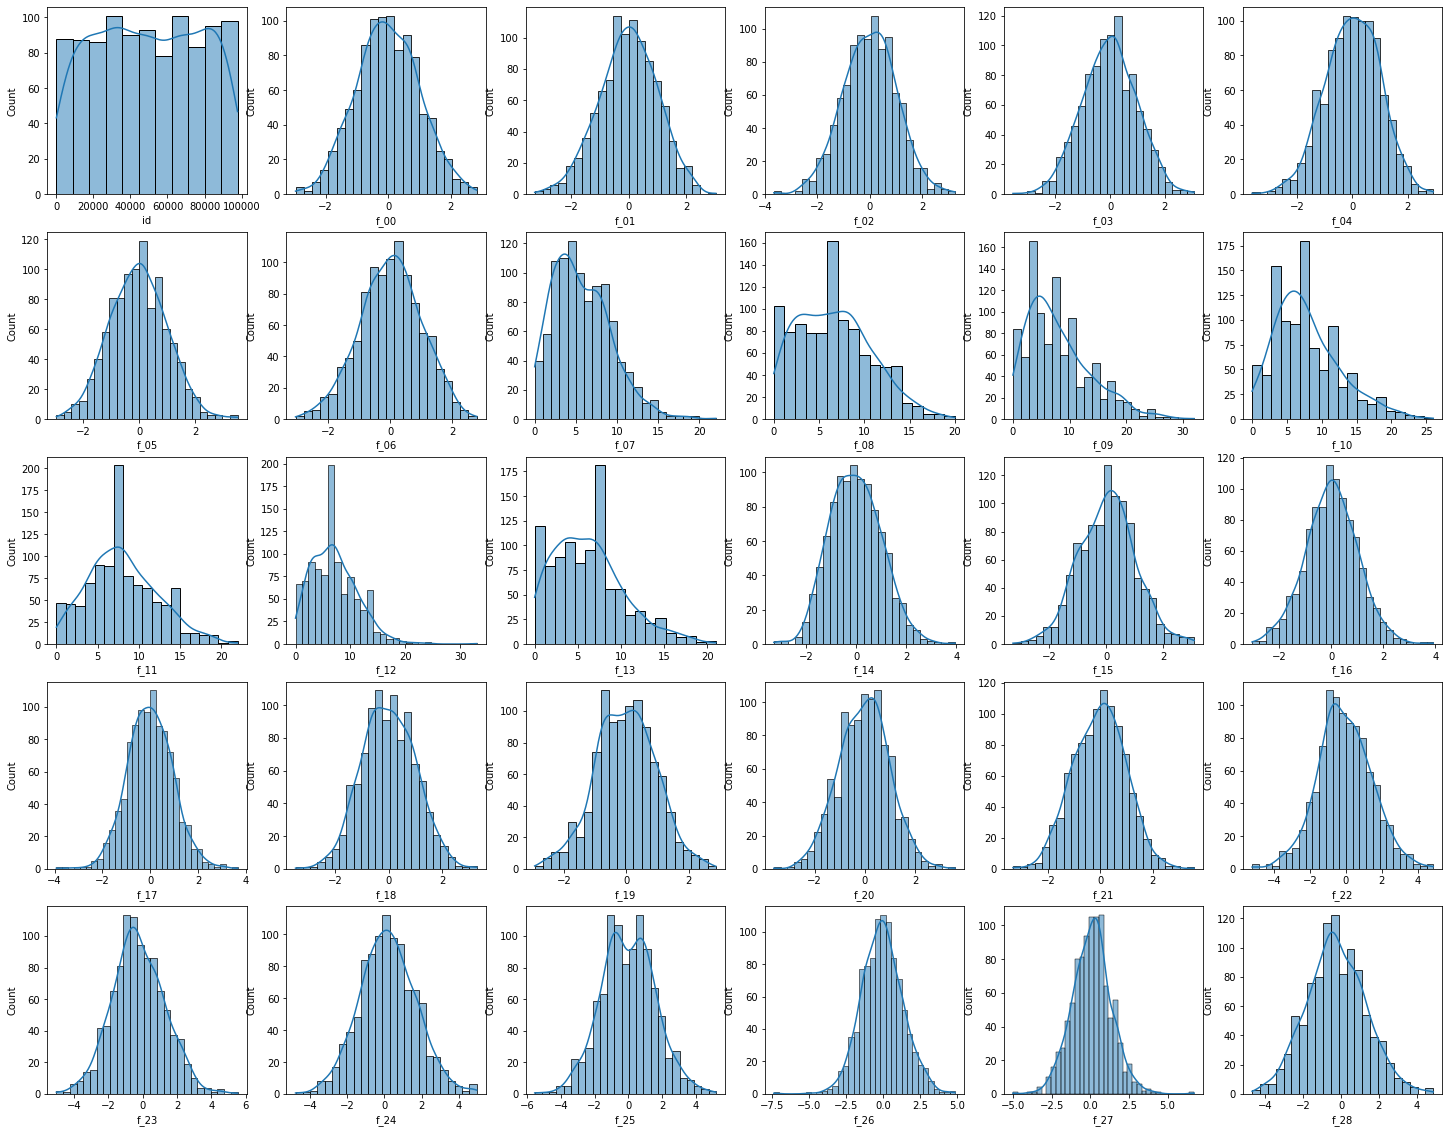

In [9]:
plt.figure(figsize = (25,20))
for i,column in enumerate(list(data.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data = data.sample(1000),kde = True)

**Feature Engineering**

In [10]:
data = data.drop(columns = "id")

In [11]:
cols = list(data.columns)

In [12]:
float_cols = data.columns[data.dtypes == 'float']

def iqr_outliers(df,col_list):
    for col in col_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2 * iqr
        Upper_tail = q3 + 2 * iqr
        df.loc[df[col] > Upper_tail,col ] = Upper_tail
        df.loc[df[col] < Lower_tail,col] = Lower_tail
    return df


data = iqr_outliers(data,float_cols)

In [13]:
data_scaled = PowerTransformer(method = "yeo-johnson").fit_transform(data)
data_scaled = MinMaxScaler().fit_transform(data_scaled)

In [14]:
data_scaled = pd.DataFrame(data_scaled,columns = cols)
data_scaled.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0.442794,0.364782,0.592928,0.590170,0.378041,0.608511,0.837312,0.175151,0.588714,0.586435,...,0.427866,0.389883,0.383693,0.404753,0.638146,0.406952,0.632694,0.655791,0.677505,0.628052
1,0.398435,0.432877,0.593705,0.650383,0.257172,0.627832,0.490453,0.175151,0.208920,0.370471,...,0.435202,0.488433,0.233663,0.430814,0.568713,0.655737,0.500832,0.418572,0.571967,0.278010
2,0.619987,0.548332,0.323680,0.409658,0.515703,0.615979,0.797530,0.335412,0.527220,0.332528,...,0.437457,0.264833,0.673152,0.845087,0.513011,0.284756,0.433763,0.658701,0.370488,0.179035
3,0.426299,0.534173,0.535767,0.537098,0.561227,0.318606,0.524483,0.377866,0.152067,0.564770,...,0.590414,0.691483,0.575339,0.622495,0.314536,0.625911,0.343819,0.443040,0.499071,0.572794
4,0.401095,0.345968,0.456613,0.229490,0.457538,0.225022,0.619619,0.453268,0.387645,0.332528,...,0.258039,0.437478,0.544142,0.546364,0.274258,0.629040,0.427031,0.687786,0.456364,0.349529


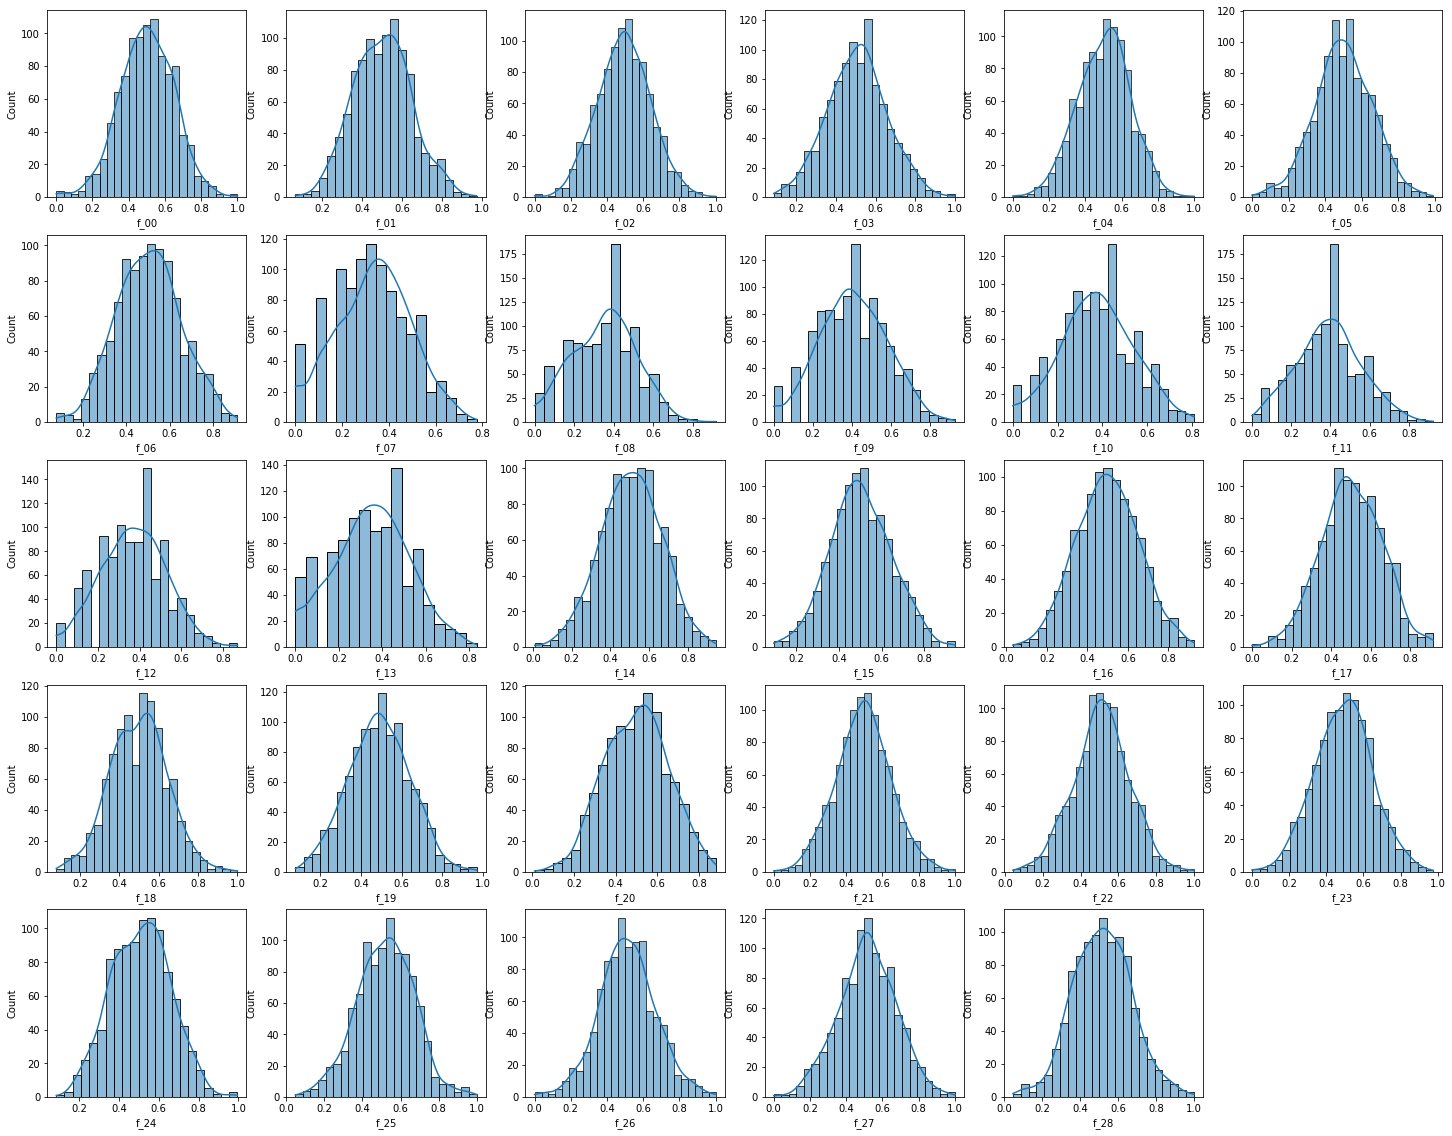

In [15]:
plt.figure(figsize = (25,20))
for i,column in enumerate(list(data_scaled.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data=data_scaled.sample(1000),kde = True)

**Model**

BayesianGaussianMixture

In [16]:
vbgmm = BayesianGaussianMixture(n_components = 7,covariance_type = 'full',random_state = 1)
preds = vbgmm.fit_predict(data_scaled)

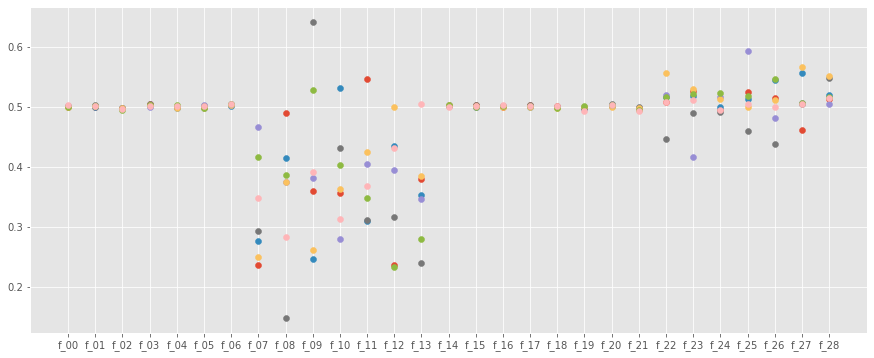

In [17]:
plt.style.use('ggplot')
plt.figure(figsize = (15,6))
for i in range(vbgmm.means_.shape[0]):
    plt.scatter(np.arange(data_scaled.shape[1]), vbgmm.means_[i])
plt.xticks(ticks = np.arange(data_scaled.shape[1]), labels=cols)
plt.show()

In [18]:
important_cols = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', ]

In [19]:
preds_vbgmm = vbgmm.fit_predict(data_scaled[important_cols])

In [20]:
pp = vbgmm.predict_proba(data_scaled[important_cols])

In [21]:
data_scaled[[f'predict_proba_{i}' for i in range(7)]] = pp 
data_scaled['predict_proba'] = np.max(pp,axis=1)
data_scaled['predict'] = np.argmax(pp,axis=1)
data_scaled

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_28,predict_proba_0,predict_proba_1,predict_proba_2,predict_proba_3,predict_proba_4,predict_proba_5,predict_proba_6,predict_proba,predict
0,0.442794,0.364782,0.592928,0.590170,0.378041,0.608511,0.837312,0.175151,0.588714,0.586435,...,0.628052,0.003540,0.977114,3.345514e-03,4.913245e-07,0.000430,0.002443,0.013126,0.977114,1
1,0.398435,0.432877,0.593705,0.650383,0.257172,0.627832,0.490453,0.175151,0.208920,0.370471,...,0.278010,0.018725,0.000313,9.365196e-06,1.459872e-02,0.003436,0.027790,0.935128,0.935128,6
2,0.619987,0.548332,0.323680,0.409658,0.515703,0.615979,0.797530,0.335412,0.527220,0.332528,...,0.179035,0.000105,0.817414,1.806412e-01,1.032702e-08,0.001513,0.000017,0.000310,0.817414,1
3,0.426299,0.534173,0.535767,0.537098,0.561227,0.318606,0.524483,0.377866,0.152067,0.564770,...,0.572794,0.000054,0.000016,9.121445e-02,8.565522e-01,0.027550,0.010948,0.013666,0.856552,3
4,0.401095,0.345968,0.456613,0.229490,0.457538,0.225022,0.619619,0.453268,0.387645,0.332528,...,0.349529,0.000184,0.000005,8.719364e-06,9.055671e-07,0.979814,0.000003,0.019985,0.979814,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,0.535521,0.745713,0.394678,0.549306,0.456225,0.548491,0.741416,0.335412,0.387645,0.436256,...,0.592760,0.003079,0.014412,1.817999e-01,1.248354e-03,0.093740,0.222363,0.483359,0.483359,6
97996,0.548102,0.605511,0.580098,0.305548,0.447599,0.526665,0.530367,0.236047,0.460718,0.182187,...,0.619857,0.009418,0.000694,1.812307e-05,1.229678e-08,0.420971,0.536817,0.032082,0.536817,5
97997,0.463512,0.432048,0.777224,0.302768,0.528876,0.416695,0.447517,0.453268,0.460718,0.492499,...,0.611616,0.001130,0.006322,9.506431e-01,8.551065e-05,0.033261,0.000296,0.008263,0.950643,2
97998,0.546433,0.823908,0.609644,0.567568,0.568574,0.508909,0.454314,0.100929,0.425132,0.517968,...,0.543100,0.702307,0.000540,1.368592e-01,4.040912e-02,0.000416,0.036384,0.083084,0.702307,0


In [22]:
tr_idx = np.array([])
for n in range(7):
    idx = data_scaled[(data_scaled["predict"] == n) & (data_scaled["predict_proba"] > 0.7)].index 
    tr_idx = np.concatenate((tr_idx, idx))
    
X = data_scaled.loc[tr_idx][important_cols]
y = data_scaled.loc[tr_idx]['predict']

In [23]:
X.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
27.0,0.335412,0.558520,0.289877,0.728651,0.474599,0.218860,0.406460,0.604287,0.452874,0.323499,0.680561,0.204453,0.583067,0.433208
28.0,0.236047,0.673711,0.240781,0.542930,0.362459,0.478690,0.223866,0.466687,0.413018,0.299842,0.674630,0.552300,0.268302,0.601187
33.0,0.416936,0.347897,0.240781,0.617691,0.279222,0.506503,0.323185,0.515914,0.532820,0.204170,0.641895,0.638131,0.536917,0.677024
36.0,0.416936,0.460718,0.332528,0.707579,0.279222,0.449345,0.444046,0.507840,0.523262,0.042796,0.847759,0.805791,0.521495,0.380312
55.0,0.288628,0.617915,0.182187,0.542930,0.279222,0.384977,0.366363,0.497303,0.390509,0.553619,0.431047,0.485006,0.425676,0.279000


In [24]:
y

27.0       0
28.0       0
33.0       0
36.0       0
55.0       0
          ..
97941.0    6
97949.0    6
97956.0    6
97981.0    6
97994.0    6
Name: predict, Length: 72710, dtype: int64

LightGBM

In [25]:
lgbm_predict_proba = 0 
kf = StratifiedKFold(5, shuffle = True, random_state = 1)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X,y)):   
    print("*****Fold {}*****".format(fold+1))
    tr_X,val_X = X.iloc[tr_idx],X.iloc[val_idx]
    tr_y,val_y = y.iloc[tr_idx],y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(tr_X,tr_y)
    lgb_eval = lgb.Dataset(val_X,val_y)
    
    params = {'learning_rate': 0.07,
              'objective': 'multiclass',
              "metric" : "multi_logloss",
              'boosting': 'gbdt',
              'verbosity': -1,
              'n_jobs': -1,
              'num_classes':7} 
    
    model = lgb.train(params, 
                      lgb_train,
                      valid_sets = [lgb_train,lgb_eval],
                      num_boost_round = 5000, 
                      callbacks = [ lgb.early_stopping(stopping_rounds = 100, verbose = True), lgb.log_evaluation(period = 100)])  

    lgbm_predict_proba += model.predict(data_scaled[important_cols])

preds = np.argmax(lgbm_predict_proba/5,axis=1)

*****Fold 1*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0469632	valid_1's multi_logloss: 0.08439
[200]	training's multi_logloss: 0.00953472	valid_1's multi_logloss: 0.0419393
[300]	training's multi_logloss: 0.00249429	valid_1's multi_logloss: 0.0303273
[400]	training's multi_logloss: 0.000715278	valid_1's multi_logloss: 0.0257875
[500]	training's multi_logloss: 0.00021199	valid_1's multi_logloss: 0.0239216
[600]	training's multi_logloss: 6.3844e-05	valid_1's multi_logloss: 0.0231688
[700]	training's multi_logloss: 1.93894e-05	valid_1's multi_logloss: 0.0232665
Early stopping, best iteration is:
[605]	training's multi_logloss: 6.02074e-05	valid_1's multi_logloss: 0.023143
*****Fold 2*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0482541	valid_1's multi_logloss: 0.0803607
[200]	training's multi_logloss: 0.00991997	valid_1's multi_logloss: 0.0394949
[300]	training's multi_loglos

**Submission**

In [26]:
sub["Predicted"] = preds

In [27]:
sub.to_csv('submission.csv', index=False)